In [759]:
#import the needed packages and other cool stuff you need to rune verything
from plantcv import plantcv as pcv
import matplotlib
import cv2
import numpy as np
import argparse 
from  matplotlib import pyplot as plt
import os
from skimage import exposure, img_as_float

#set debug to plot so that you can see what is happening to the image
%matplotlib inline
pcv.params.debug = "plot"
pcv.__version__


# AB BECAUSE USING 'A' AND 'B' CHANNELS 

'3.14.3+942.ge1c4fda1'

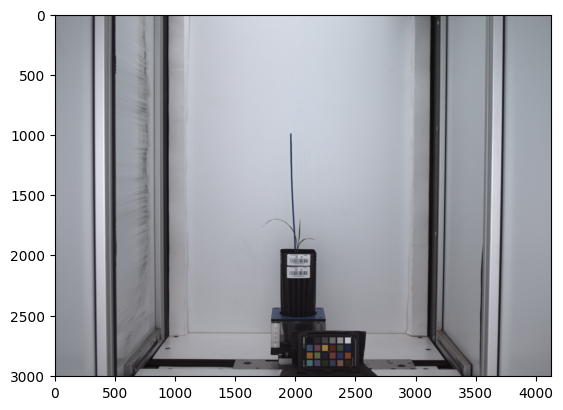

In [760]:
plant1, _, _ = pcv.readimage("/Users/jstanton/desktop/july/7_19/VIS_SV_0_z1_h1_g370_e1500_v500_6011_0.png")

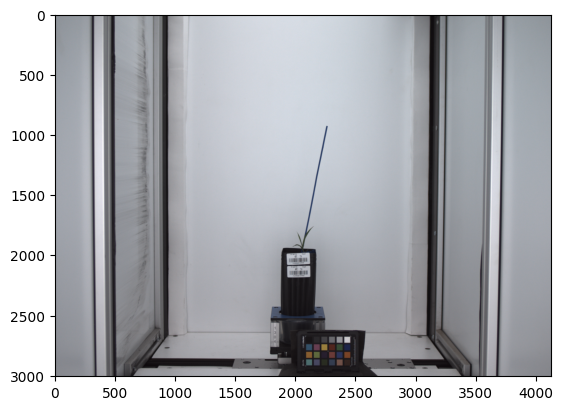

In [761]:
plant2, _, _ = pcv.readimage("/Users/jstanton/desktop/august/8_2/VIS_SV_0_z1_h1_g370_e1500_v500_94889_0.png")

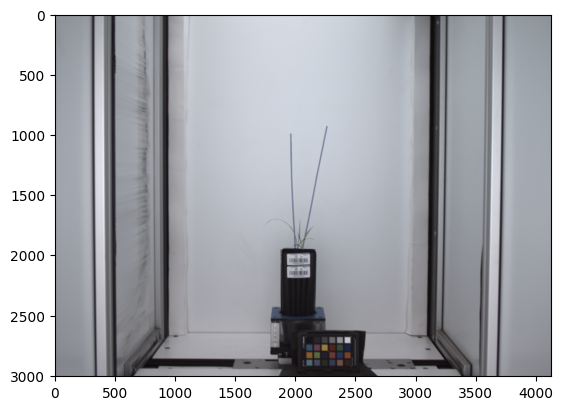

In [762]:
pcv.params.debug = "plot" 
_ = pcv.visualize.overlay_two_imgs(plant1,plant2)

In [763]:
#import a sample image and define it to use later in the notebook
class options:
    def __init__(self):
        # Input image path/filename
        self.image = "/Users/jstanton/desktop/august/8_14/VIS_SV_0_z1_h1_g370_e1500_v500_167972_0.png"
        self.image2 = "/Users/jstanton/desktop/august/8_14/NIR_SV_0_z1_h1_g0_e21500_v500_167975_0.png"
        self.image3 = "/Users/jstanton/desktop/imgs/empty_pot.png"
        self.image4 = "/Users/jstanton/desktop/imgs/color_card.png"
        self.image5 = "/Users/jstanton/desktop/imgs/nir_card.png"
        # Debug mode = None, "plot", or "print"
        self.debug = "plot"
        # Store output images (True/False)
        self.writeimg = False
        # Results path/filename
        self.result = "data_output"
        # Image output directory path
        self.outdir = "img_output"

args = options()
pcv.params.debug_outdir = args.outdir
pcv.params.debug = args.debug

# Increase text size in plots
pcv.params.text_size = 20
pcv.params.text_thickness = 10

In [764]:
def affine_color_correction(img, source_matrix, target_matrix):
    h,w,c = img.shape
    n = source_matrix.shape[0]
    S = np.concatenate((source_matrix[:,1:].copy(),np.ones((n,1))),axis=1)
    T = target_matrix[:,1:].copy()
    
    tr = T[:,0]
    tg = T[:,1]
    tb = T[:,2]
    
    ar = np.matmul(np.linalg.pinv(S), tr)
    ag = np.matmul(np.linalg.pinv(S), tg)
    ab = np.matmul(np.linalg.pinv(S), tb)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pix = np.concatenate((img_rgb.reshape(h*w,c).astype(np.float64)/255, np.ones((h*w,1))), axis=1)
    
    img_r_cc = (255*np.clip(np.matmul(img_pix,ar),0,1)).astype(np.uint8)
    img_g_cc = (255*np.clip(np.matmul(img_pix,ag),0,1)).astype(np.uint8)
    img_b_cc = (255*np.clip(np.matmul(img_pix,ab),0,1)).astype(np.uint8)
    
    img_cc = np.stack((img_b_cc,img_g_cc,img_r_cc), axis=1).reshape(h,w,c)
    
    return img_cc

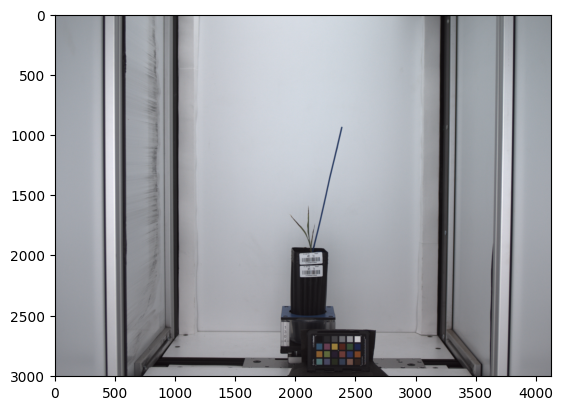

In [765]:
#define your images and your image to color correct to
img, path, filename = pcv.readimage(filename=args.image)

In [766]:
# #define the function to color correct lemnatec bellwether images, specific to July 2022 with the older camera
# def log_correct_v(img, max_val=255):
    
#     img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     img_hsv_f = img_hsv.astype(np.float64)
#     log_imgv = np.log(img_hsv_f[:,:,2]+1)

#     log_imgv = log_imgv - np.min(log_imgv)
#     log_imgv = max_val*(log_imgv/np.max(log_imgv))

#     img_hsv_f_corrected = img_hsv_f.copy()
#     img_hsv_f_corrected[:,:,2] = log_imgv

#     img_hsv_c = np.clip(img_hsv_f_corrected,0,max_val).astype(np.uint8)

#     img_corrected = cv2.cvtColor(img_hsv_c, cv2.COLOR_HSV2BGR)

#     pcv.plot_image(img_corrected)
    
#     return img_corrected


In [767]:
#perform log correction using your defined function
plant_logv = img

In [768]:
#define the color card dataframe for the image you are playing with
dataframe2, start2, space2 = pcv.transform.find_color_card(rgb_img=plant_logv, background='light')

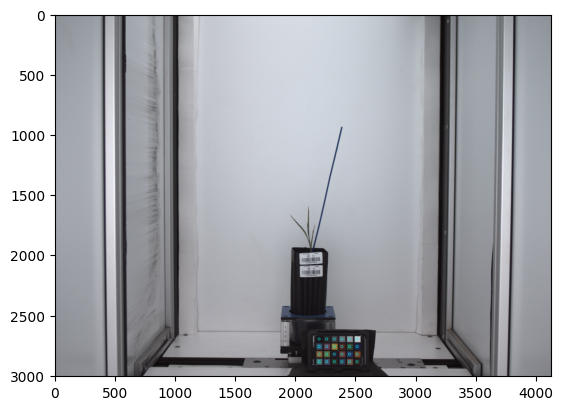

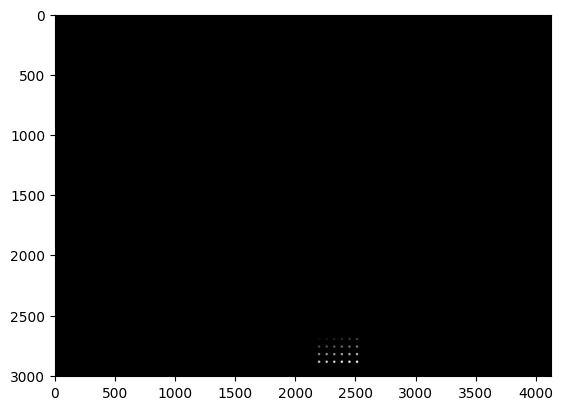

In [769]:
#make a color card mask for your image that you are playing with here

source_mask = pcv.transform.create_color_card_mask(plant_logv, radius=10, start_coord=start2, 
                                                   spacing=space2, nrows=4, ncols=6)

In [770]:
#make color card matrix for image you are playing with
headers, source_matrix = pcv.transform.get_color_matrix(rgb_img=plant_logv, mask=source_mask)

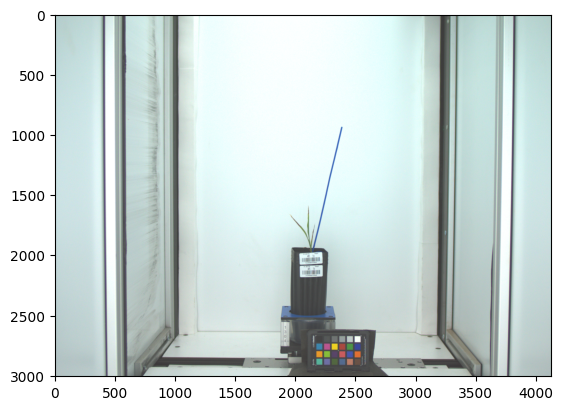

In [771]:
#load the color card values that they should be
target_matrix = pcv.transform.load_matrix(filename='/Users/jstanton/Coding/Danforth_Projects/PlantCV/PlantCV_Workflows/x-rite_color_matrix_k2.npz')

color_corrected_img = affine_color_correction(plant_logv, source_matrix, target_matrix)

pcv.plot_image(color_corrected_img)

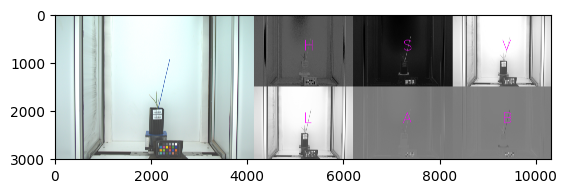

In [772]:
# Update params related to plotting so we can see better 
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20


#visualize the colorspace so you can tell which channels will be the most interesting
colorspace_img = pcv.visualize.colorspaces(rgb_img=color_corrected_img)

In [773]:
pcv.print_image(color_corrected_img, filename = "/Users/jstanton/desktop/color_corrected_img.png")

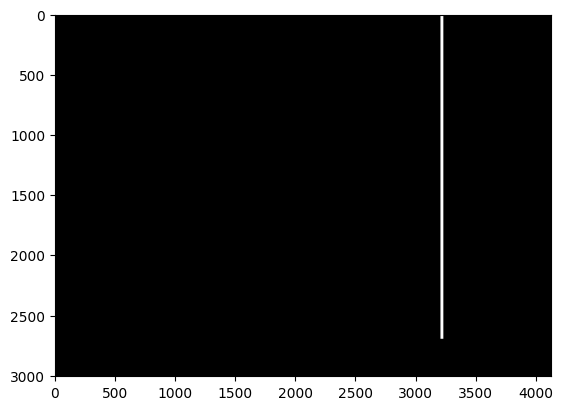

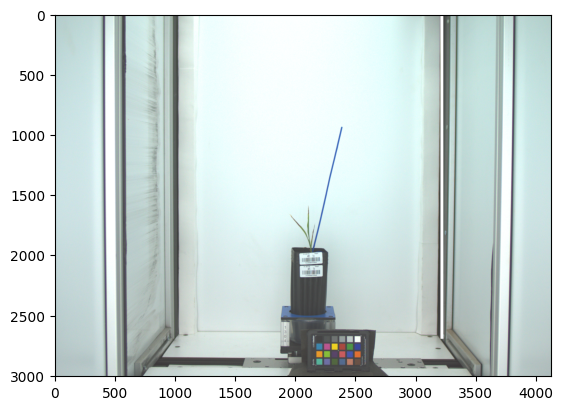

In [774]:
box_right_img, binary, contours, hierarchy = pcv.rectangle_mask(img=color_corrected_img, p1=(3200,2696), p2=(3223,2), color = "white")

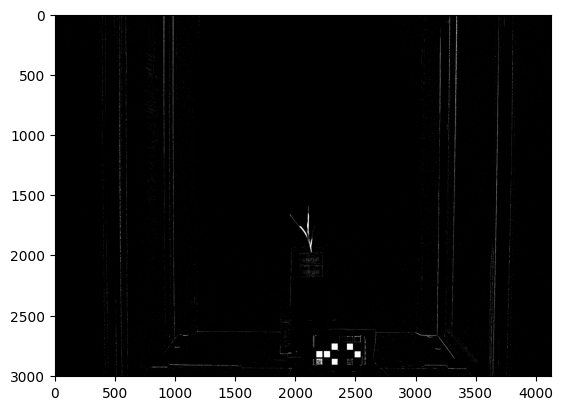

In [775]:
## THRESHOLDING ##
thresh1 = pcv.threshold.dual_channels(rgb_img = box_right_img, x_channel = "a", y_channel = "b", points = [(90,130),(131,146)], above=True, max_value=255)

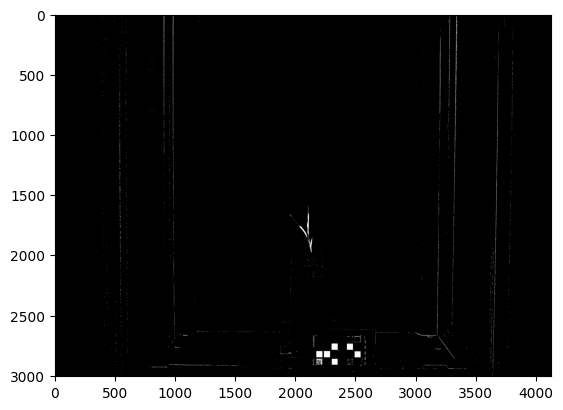

In [776]:
#get rid of noise
thresh1_fill = pcv.fill(bin_img=thresh1, size=3.5)

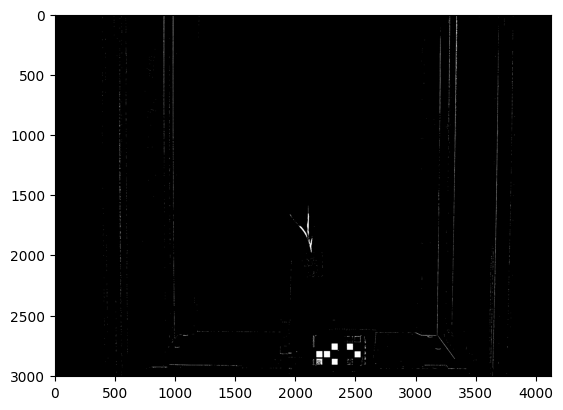

In [777]:
# Fill in small objects #does not even take a sizing parameter #obviouspepper
thresh1_filled_holes = pcv.closing(gray_img=thresh1_fill)

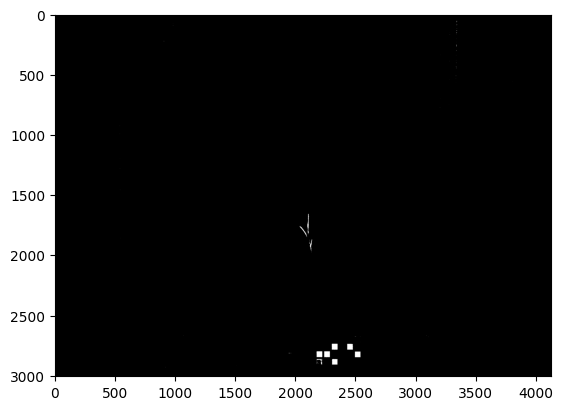

In [778]:
# use erode function here
er_img = pcv.erode(gray_img=thresh1_filled_holes, ksize=4, i=1)

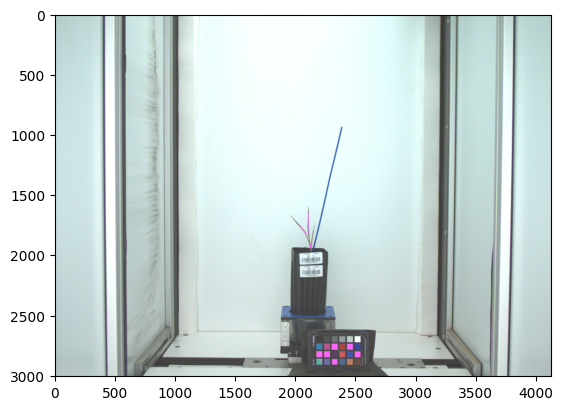

In [779]:
id_objects_ab, obj_hierarchy_ab = pcv.find_objects(img=color_corrected_img, mask=er_img)

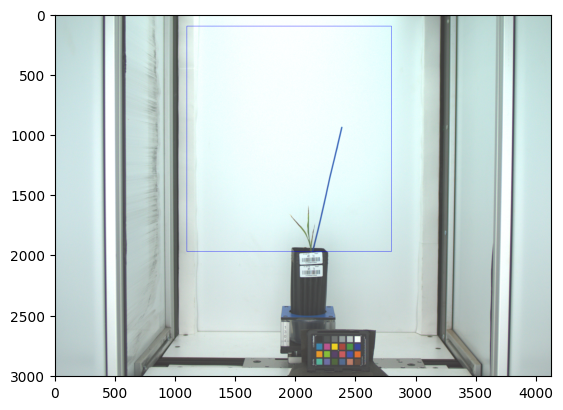

In [780]:
roi_ab, roi_hierarchy_ab= pcv.roi.rectangle(img=color_corrected_img, x=1094, y=100, h=1872, w=1700)

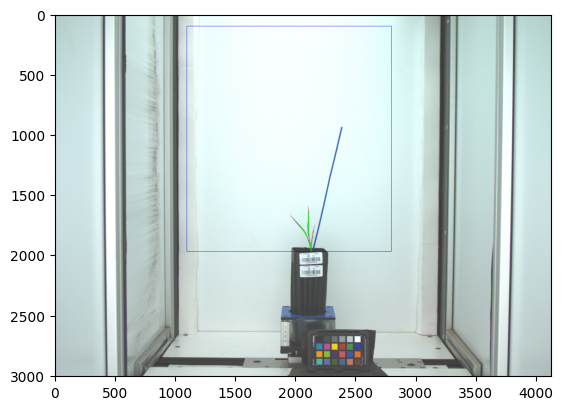

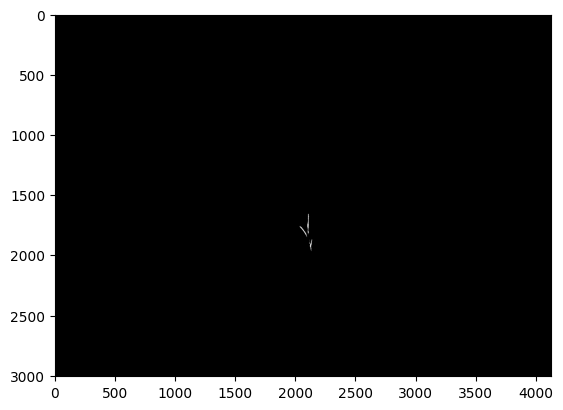

In [781]:
roi_objects_ab, hierarchy_ab, kept_mask_ab, obj_area_ab = pcv.roi_objects(img=color_corrected_img, roi_contour=roi_ab, 
                                                               roi_hierarchy=roi_hierarchy_ab, 
                                                               object_contour=id_objects_ab, 
                                                               obj_hierarchy=obj_hierarchy_ab,
                                                               roi_type='partial')

In [782]:
## ALIGNING COLOR CARD IMAGES TO GET COORDINATE POINTS TO ALIGN IMAGES FOR WARPING ##

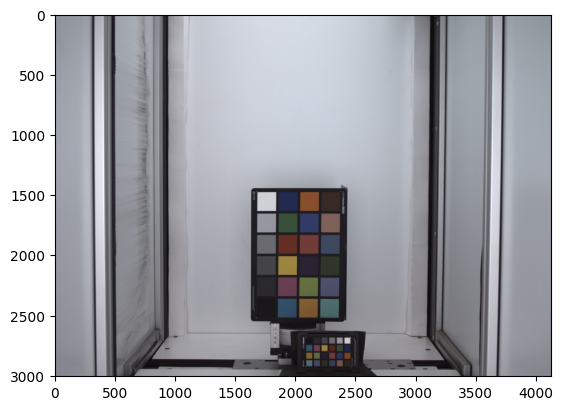

In [783]:
color, path1, filename1 = pcv.readimage(filename=args.image4, mode='native')

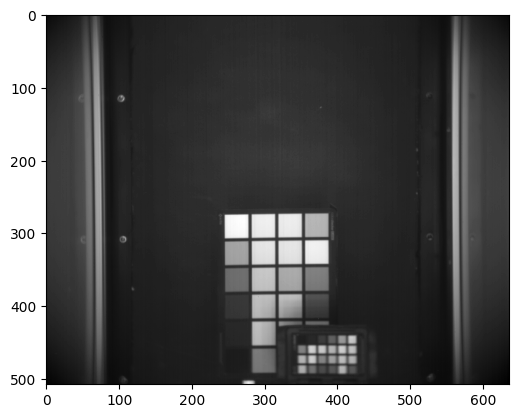

In [784]:
nir_color_card, path1, filename1 = pcv.readimage(filename=args.image5, mode='native')

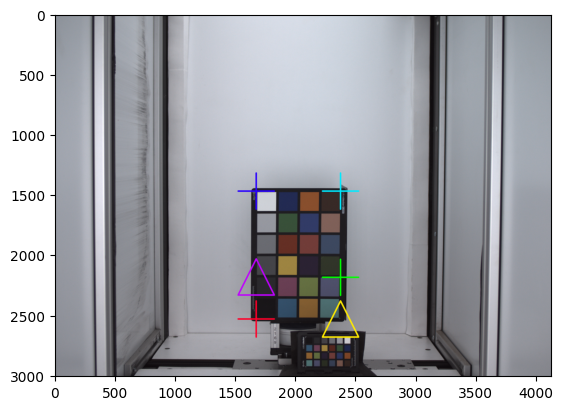

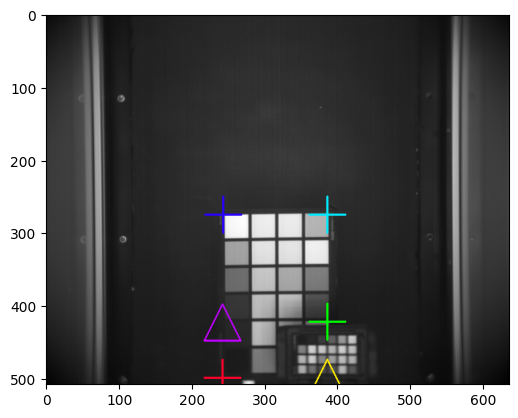

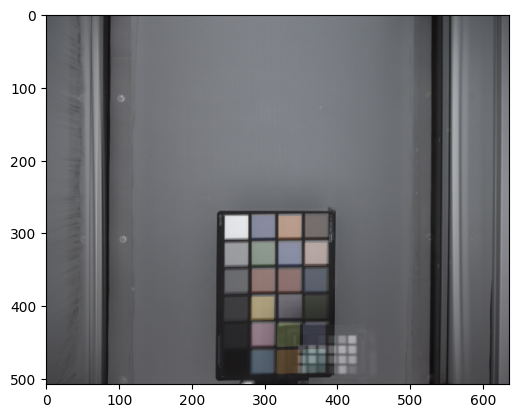

In [785]:
## Apply landmark transformation to align both images 

# plotting params
pcv.params.marker_size = 50
pcv.params.line_thickness = 2

# img_warped, mat = pcv.transform.warp(img=color, refimg=nir_color_card,
#                                      pts=[(1670, 1480), (2370, 1470), (2380, 2186), (2370, 2539), (1685, 2542), (1685, 2183)],
#                                       refpts=[(243,275), (386,275), (386, 422), (386, 499), (242, 499), (242, 423)],
#                                      method='lmeds')

img_warped, mat = pcv.transform.warp(img=color, refimg=nir_color_card,
                                     
                                      pts=[(1670, 1470), (2370, 1470), (2370, 2186), (2370, 2532), (1670, 2532), (1670, 2183)],
                                      refpts=[(243,275), (386,275), (386, 422), (386, 499), (242, 499), (242, 423)],
                                      method='lmeds')


In [786]:
######### NIR IMAGE ANALYSIS BEGINS########

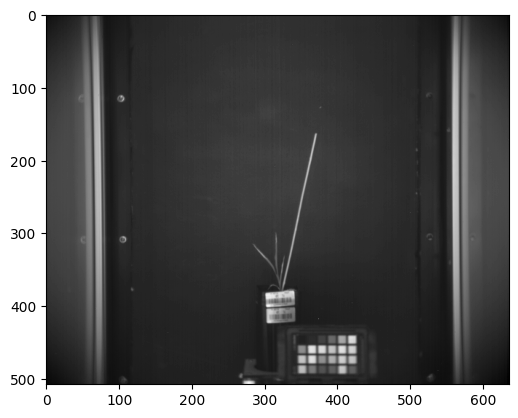

In [787]:
# Read in NIR image

nir, path1, filename1 = pcv.readimage(filename=args.image2, mode='native')

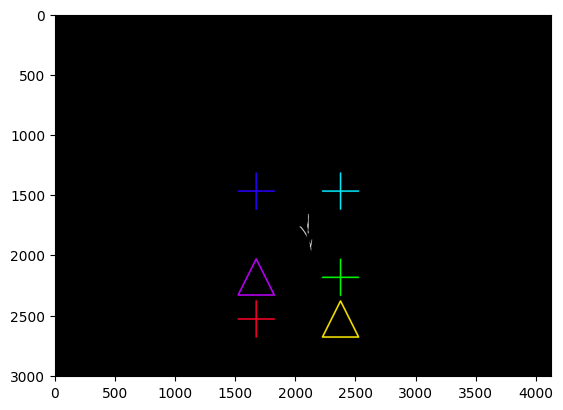

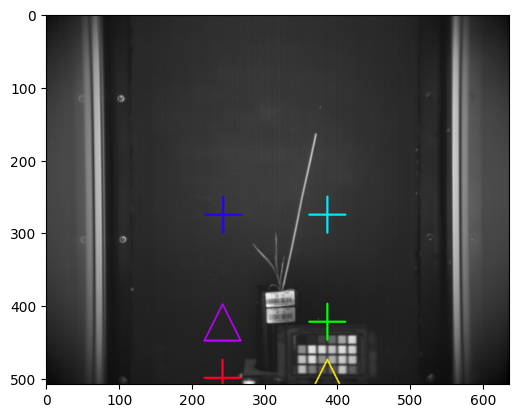

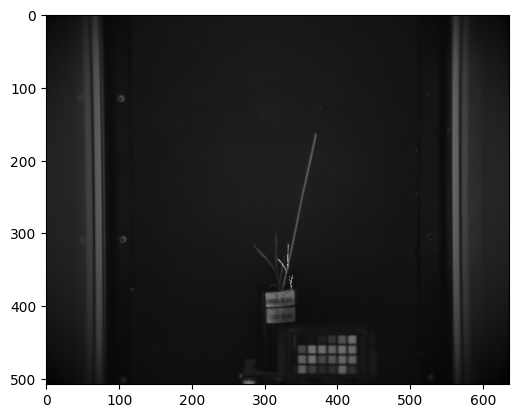

In [788]:
# Apply landmark transformation (we chose to use the screws in the background) to align both images 

img_warped, mat = pcv.transform.warp(img=kept_mask_ab, refimg=nir,
                                      pts=[(1670, 1470), (2370, 1470), (2370, 2186), (2370, 2532), (1670, 2532), (1670, 2183)],
                                      refpts=[(243,275), (386,275), (386, 422), (386, 499), (242, 499), (242, 423)],
                                      method='lmeds')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


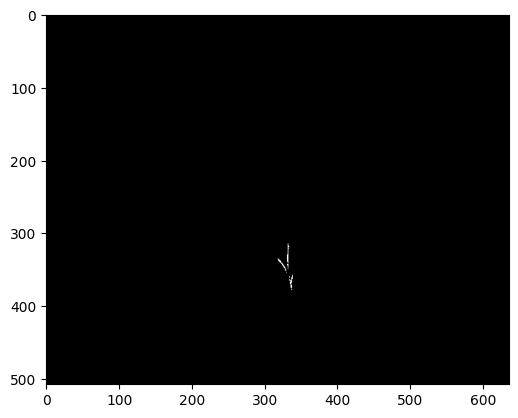

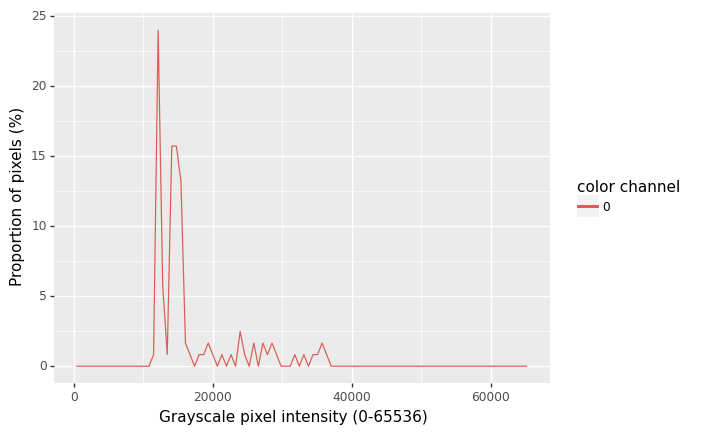

In [794]:
# Analyze NIR pixel intensity values of the plant

nir_hist = pcv.analyze_nir_intensity(gray_img=nir, mask=img_warped, bins=100, label="NIR")

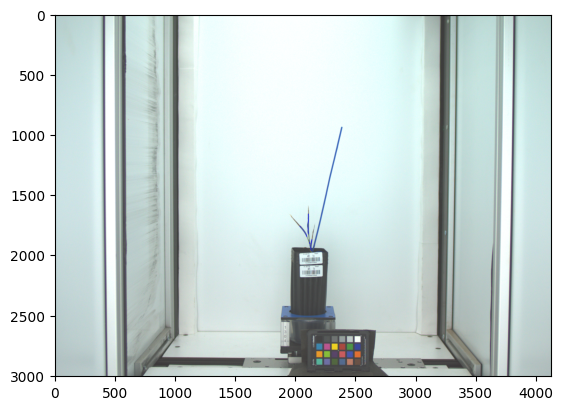

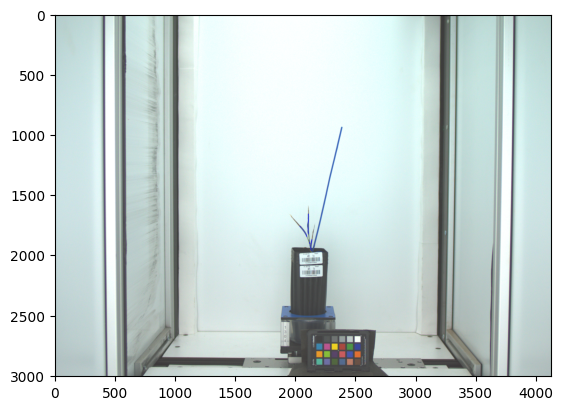

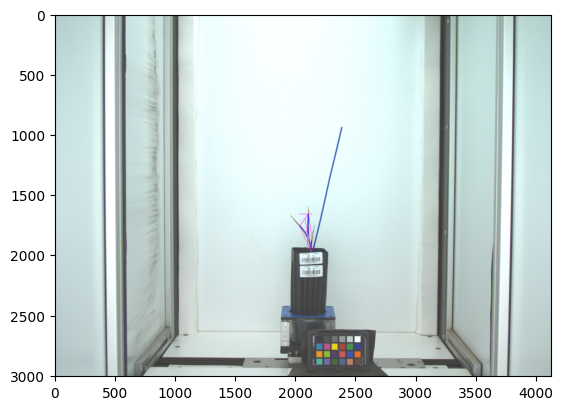

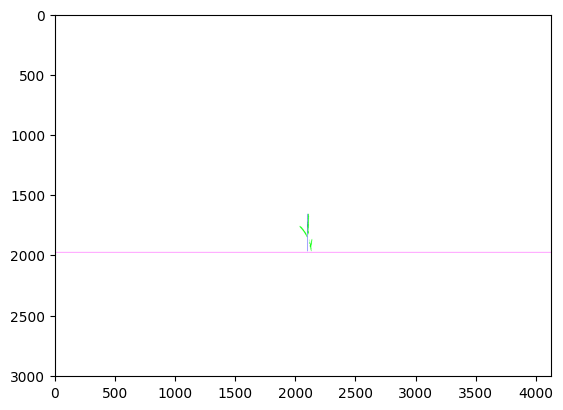

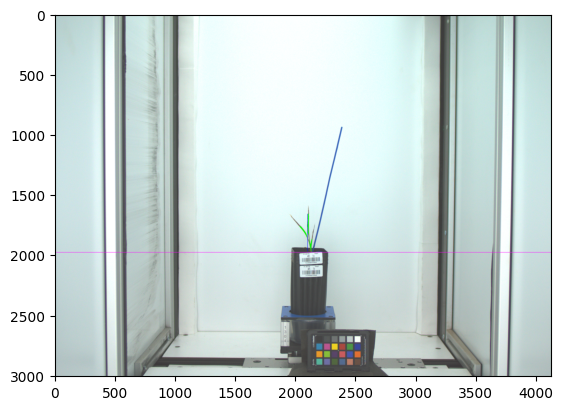

In [790]:
# If pot not empty: object combine kept objects
if obj_area_ab > 4:
    #combine kept objects
    obj_combined_ab, kept_mask_ab = pcv.object_composition(img=color_corrected_img, contours=roi_objects_ab, hierarchy=hierarchy_ab)

    # Find shape properties, data gets stored to an Outputs class automatically
    analysis_image = pcv.analyze_object(img=color_corrected_img, obj=obj_combined_ab, mask=kept_mask_ab, label="default")
    boundary_image = pcv.analyze_bound_horizontal(img=color_corrected_img, obj=obj_combined_ab, mask=kept_mask_ab, 
                                               line_position=1982, label="default")

In [791]:
#pcv.outputs.save_results(filename=args.result)